In [5]:
import csv
import re

clean_names = []

with open('../dognames_raw.csv') as f:
    reader = csv.reader(f)
    for [name, count] in reader:
        # we keep names that are only letters and longer than 1 character
        if(re.search("[^a-zA-Z]", name) is None and len(name) > 1):
            clean_names.append(name.lower())
            
f = open('../dognames_clean.csv', 'w')
f.write('\n'.join(clean_names))
f.close()

In [7]:
words = open('../dognames_clean.csv').read().splitlines()
words[:10]

['march',
 'april',
 'august',
 'december',
 'sunday',
 'monday',
 'friday',
 'jan',
 'jun',
 'january']

In [8]:
vocab_size = len(set(''.join(words))) + 1 # +1 for the padding symbol

In [9]:
chars = sorted(list(set(''.join(words)))) # sorted list of unique characters
chars = ['.'] + chars # add padding symbol to the beginning of the list
stoi = {c:i for i,c in enumerate(chars)} # char to index mapping
itos = {i:c for i,c in enumerate(chars)} # index to char mapping

In [10]:
stoi

{'.': 0,
 'a': 1,
 'b': 2,
 'c': 3,
 'd': 4,
 'e': 5,
 'f': 6,
 'g': 7,
 'h': 8,
 'i': 9,
 'j': 10,
 'k': 11,
 'l': 12,
 'm': 13,
 'n': 14,
 'o': 15,
 'p': 16,
 'q': 17,
 'r': 18,
 's': 19,
 't': 20,
 'u': 21,
 'v': 22,
 'w': 23,
 'x': 24,
 'y': 25,
 'z': 26}

In [11]:
import torch

### Probability table

In [12]:
N = torch.ones((vocab_size, vocab_size), dtype=torch.int32)

for w in words:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        N[stoi[ch1], stoi[ch2]] += 1

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

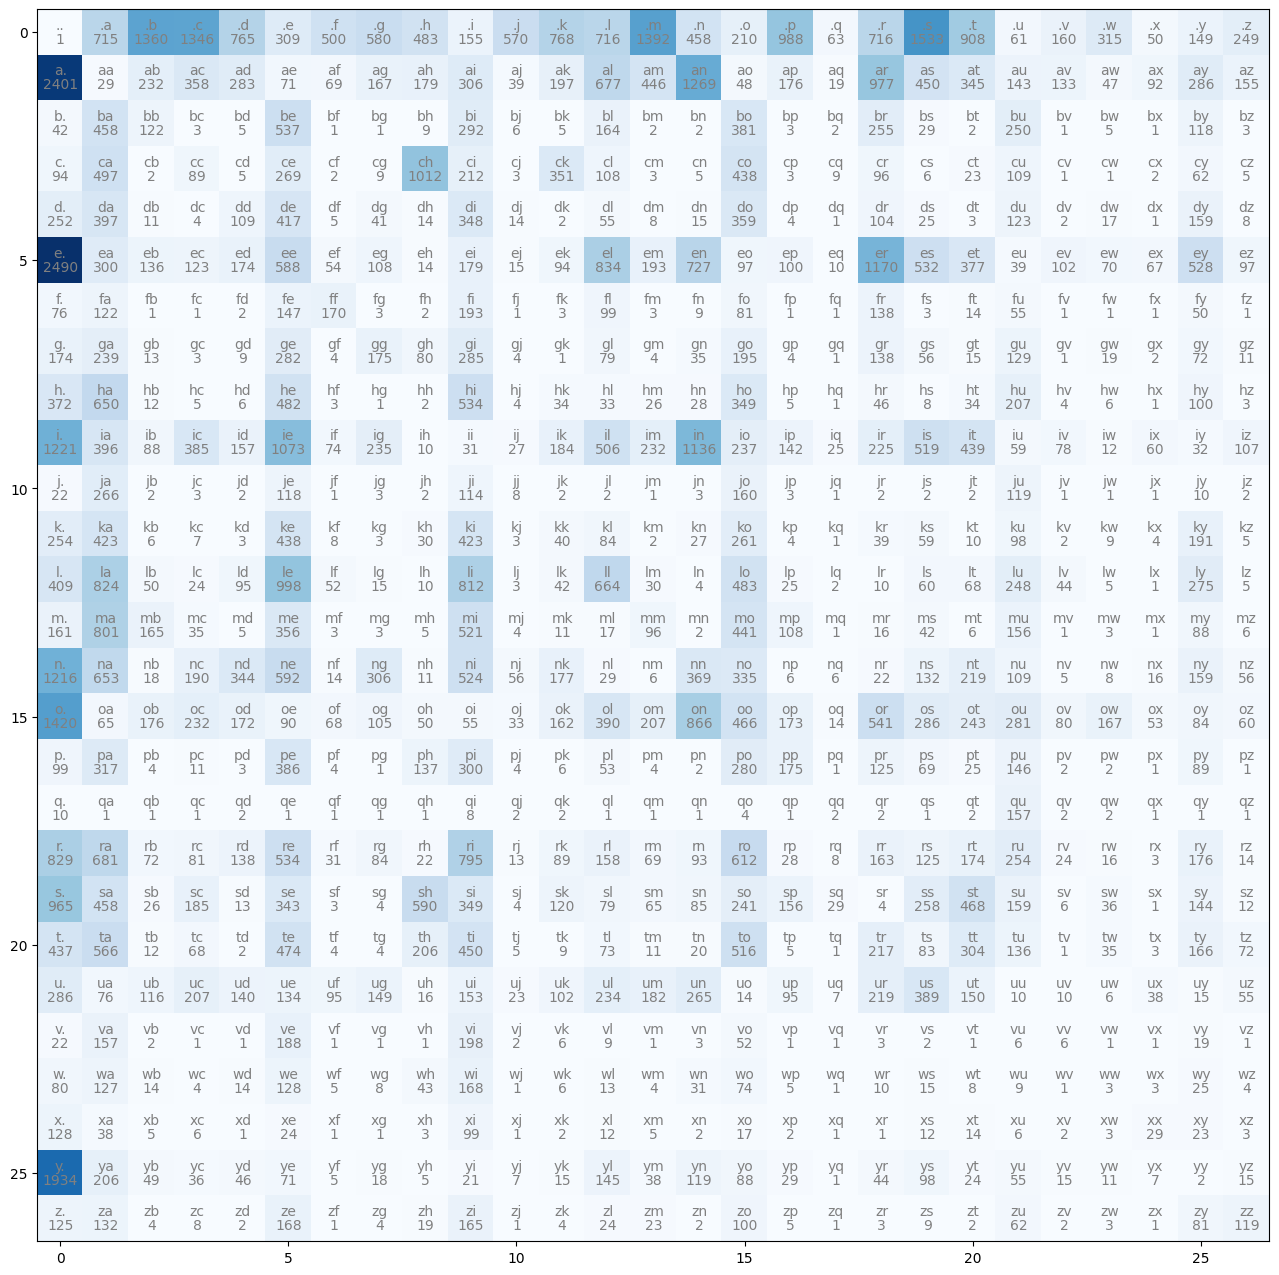

In [14]:
plt.figure(figsize=(16,16))
plt.imshow(N, cmap="Blues")
for i in range(vocab_size):
    for j in range(vocab_size):
        chstr = itos[i] + itos[j]
        plt.text(j, i, chstr, ha="center", va="bottom", color="gray")
        plt.text(j, i, N[i, j].item(), ha="center", va="top", color="gray")

In [15]:
# probability of a character given the previous character
P = N.float() / N.sum(dim=1, keepdim=True)

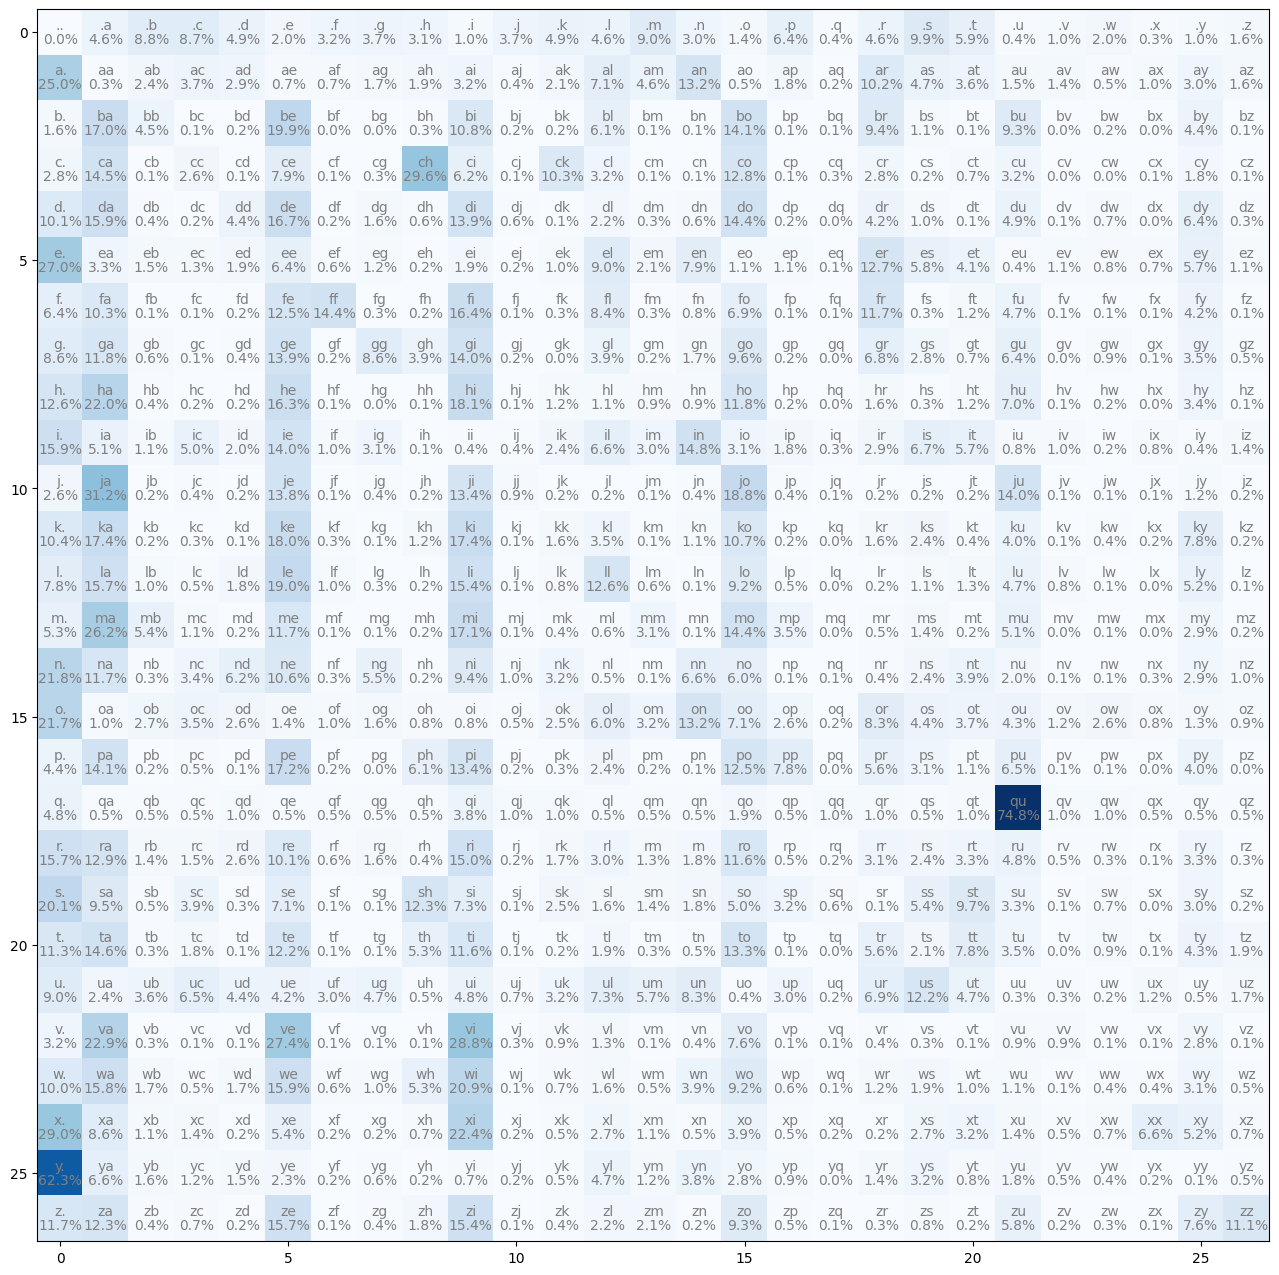

In [16]:
plt.figure(figsize=(16,16))
plt.imshow(P, cmap="Blues")
for i in range(vocab_size):
    for j in range(vocab_size):
        chstr = itos[i] + itos[j]
        plt.text(j, i, chstr, ha="center", va="bottom", color="gray")
        plt.text(j, i, str(round((P[i, j]*100).item(), 1)) + "%", ha="center", va="top", color="gray")

In [17]:
# generating names
for i in range(10):
    out = []
    ix = 0
    while True:
        ix = torch.multinomial(P[ix], 1, replacement=True).item()
        if ix == 0:
            break
        out.append(itos[ix])
    print(''.join(out))

miunowa
tai
ba
ly
bu
mopiinde
bll
co
cova
sirfriniliovila


In [18]:
# calculating the negative log-likelihood

logs = 0
counter = 0
for w in words:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1, ix2 = stoi[ch1], stoi[ch2]
        prob = P[ix1, ix2]
        logs += torch.log(prob)
        counter += 1
nll = -logs / counter
print(f'{nll=}')

nll=tensor(2.5650)


### Neural network

In [34]:
# creating training set
xs, ys = [], []
for w in words:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        xs.append(stoi[ch1])
        ys.append(stoi[ch2])
        
xs = torch.tensor(xs)
ys = torch.tensor(ys)

In [35]:
import torch.nn.functional as F
xs_enc = F.one_hot(xs, vocab_size).float()

In [36]:
W = torch.randn((vocab_size, vocab_size), requires_grad=True)

In [38]:
# training

for i in range(1000):
    # forward pass
    logits = xs_enc @ W
    counts = logits.exp()
    probs = counts / counts.sum(dim=1, keepdim=True)
    loss = -probs[torch.arange(ys.numel()), ys].log().mean()
    
    # backward pass
    W.grad = None
    loss.backward()
    
    # update
    W.data -= 1 * W.grad.data
    
    print(f'{loss.item()}')

2.6871109008789062
2.6869752407073975
2.6868398189544678
2.686704397201538
2.6865694522857666
2.686434507369995
2.68630051612854
2.6861660480499268
2.6860318183898926
2.685898542404175
2.685764789581299
2.685631513595581
2.6854989528656006
2.685365915298462
2.6852331161499023
2.68510103225708
2.684968948364258
2.6848371028900146
2.6847057342529297
2.684574604034424
2.684443235397339
2.684312582015991
2.6841819286346436
2.684051752090454
2.6839215755462646
2.6837918758392334
2.683661937713623
2.683532476425171
2.683403253555298
2.683274507522583
2.6831459999084473
2.6830174922943115
2.6828887462615967
2.6827611923217773
2.682633638381958
2.6825056076049805
2.6823785305023193
2.682251453399658
2.682124376296997
2.681997537612915
2.6818714141845703
2.6817452907562256
2.68161940574646
2.6814937591552734
2.681368112564087
2.6812429428100586
2.6811180114746094
2.680992841720581
2.68086838722229
2.680744171142578
2.680619955062866
2.6804959774017334
2.6803717613220215
2.680248498916626
2.6801

In [40]:
# generating names
for i in range(10):
    out = []
    ix = 0
    while True:
        xs_enc = F.one_hot(torch.tensor([ix]), vocab_size).float()
        # forward pass
        logits = xs_enc @ W
        counts = logits.exp()
        probs = counts / counts.sum(dim=1, keepdim=True)
        ix = torch.multinomial(probs, 1, replacement=True).item()
        if ix == 0:
            break
        out.append(itos[ix])
    print(''.join(out))

chelie
chonammittandokemapywde
ant
ilulofcri
a
belaronnrrguuntzeuetzjewa
joladaenvtya
cwtowkerdmokyie
buangy
jacja
